This notebook trains an LSTM neural network to predict APPL price data. Written and Developed by Aaron Lozhkin.

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import datetime as dt

import math
!pip install pandas_ta
import pandas_ta as pta
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
  print("WARNING: Model will train slow on cpu. If on colab, go to Runtime->Change Runtime Type->Hardware Accelerator->GPU. If not on colab consider running on local or remote GPU.")

In [58]:
# Download APPL Intraday Price Data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GiYmpQ5szqAGzm3e_KCFtceCYOF3hXek" -O AAPL_1min.txt && rm -rf /tmp/cookies.txt
source_path = '/content/AAPL_1min.txt'

--2023-07-25 19:25:56--  https://docs.google.com/uc?export=download&confirm=&id=1GiYmpQ5szqAGzm3e_KCFtceCYOF3hXek
Resolving docs.google.com (docs.google.com)... 172.217.193.101, 172.217.193.100, 172.217.193.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.193.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eiugnq4b6f21le2mj6vn3g51u9n5b1h0/1690313100000/16949169962997158638/*/1GiYmpQ5szqAGzm3e_KCFtceCYOF3hXek?e=download&uuid=04b6fa53-aecb-422c-b253-00bc26f9d78e [following]
--2023-07-25 19:25:58--  https://doc-0k-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eiugnq4b6f21le2mj6vn3g51u9n5b1h0/1690313100000/16949169962997158638/*/1GiYmpQ5szqAGzm3e_KCFtceCYOF3hXek?e=download&uuid=04b6fa53-aecb-422c-b253-00bc26f9d78e
Resolving doc-0k-5c-docs.googleusercontent.com (doc-0k-5c-docs.googleusercontent.com)... 172.217.204.1

In [59]:
def getOldData(source_path):
    df = pd.read_csv(source_path, sep = ',')
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    return df

In [60]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def RemoveAndFormatNAN(dataset):

  # Ignore When the Market Is Closed
  dataset['Hour'] = dataset.index.hour
  dataset = dataset[dataset['Hour'] > 3]
  dataset = dataset[dataset['Hour'] < 20]
  dataset = dataset.drop('Hour', axis=1)

  # Ignore Weekends
  dataset['Day'] = dataset.index.dayofweek
  dataset = dataset[dataset['Day'] < 5]
  dataset = dataset.drop('Day', axis=1)

  #Ignore Holidays
  cal = calendar()
  holidays = [x for x in cal.holidays(start='2010-01-01', end='2019-12-31')]
  dataset = dataset[~dataset.index.normalize().isin(holidays)]

  return dataset

In [61]:
class StockDataset(Dataset):
    def __init__(self, source, sequence_length, prediction_steps):
        self.source_path = source
        self.sequence_length = sequence_length
        self.prediction_steps = prediction_steps

        df = getOldData(self.source_path)

        # Derive Technical Indicators
        ema_12 = df['Open'].ewm(span=12, adjust=False).mean()
        ema_26 = df['Open'].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema_12 - ema_26
        df['RSI14'] = pta.rsi(df['Open'], length=14)

        # Resample to 10min
        df['Datetime'] = index = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S")
        df = df.set_index(pd.DatetimeIndex(df['Datetime']))
        df = df.drop('Datetime', axis=1)

        df_10min = df.resample('10Min').mean().backfill()

        # Remove NAN
        df_10min = RemoveAndFormatNAN(df_10min)

        # Convert to NumPy array
        self.data = df_10min[['Open', 'MACD', 'RSI14', 'Close']].values

        # Scale the data
        self.scaler = MinMaxScaler()
        self.data = self.scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data) - self.sequence_length - self.prediction_steps

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length, 0:3]
        y = self.data[idx + self.sequence_length:idx + self.sequence_length + self.prediction_steps, 3]

        # Convert to PyTorch tensors
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)

        return x.to(device), y.to(device)

    def inverse_scale(self, scaled_data):
        return self.scaler.inverse_transform(scaled_data)


Adjust the number of time steps used for input and forecast. **1 time step = 10 minutes.** <br>

Default is to use 100 time steps (*1000 minutes*) of previous data to predict 50 time steps (*500 minutes*) into the future.

In [62]:
sequence_length = 100  # Number of time steps to use as input
prediction_steps = 50  # Number of time steps to forecast

In [63]:
dataset = StockDataset(source=source_path, sequence_length=sequence_length, prediction_steps=prediction_steps)
train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)

# Create dataloaders for training and testing
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

<ipython-input-61-2f3dacdb6bad>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_10min = df.resample('10Min').mean().backfill()


In [64]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, prediction_steps, dropout):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.prediction_steps = prediction_steps
        self.num_layers = num_layers

        self.linear_1 = nn.Linear(input_size, hidden_layer_size).float()
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_layer_size, prediction_steps).float()

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def forward(self, x, hidden, cell):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x, (hidden, cell))

        # layer 2
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear_2(lstm_out[:, -1, :])

        return predictions

features = 3
model = LSTMModel(input_size=features, hidden_layer_size=32, num_layers=1, prediction_steps=prediction_steps, dropout=0.03)

In [65]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0
    predictions_list = []
    targets_list = []

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        # Move data to the device used for training
        x = x.to(device)
        y = y.to(device)

        # Initialize the hidden and cell states for the LSTM model
        hidden = torch.zeros(model.num_layers, x.size(0), model.hidden_layer_size).to(device)
        cell = torch.zeros(model.num_layers, x.size(0), model.hidden_layer_size).to(device)

        # Predict using the LSTM model
        predictions = model(x.float(), hidden, cell)

        # Flatten the predictions and targets to handle sequence prediction
        predictions = predictions.view(-1, model.prediction_steps)
        y = y.view(-1, model.prediction_steps)

        # Append predictions and targets for visualization
        predictions_list.append(predictions.cpu().detach().numpy())
        targets_list.append(y.cpu().detach().numpy())

        # Calculate the loss for each prediction step
        loss = criterion(predictions, y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))

    lr = scheduler.get_last_lr()[0]

    # Convert predictions_list and targets_list to NumPy arrays
    predictions_array = np.concatenate(predictions_list, axis=0)
    targets_array = np.concatenate(targets_list, axis=0)

    return epoch_loss, lr, predictions_array, targets_array


epochs=15
learning_rate = 1e-3

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

model.to(device)

# Initialize empty lists to store training and testing losses
train_losses = []
test_losses = []

# begin training
for epoch in range(epochs):
    loss_train, lr_train, predictions_train, targets_train = run_epoch(train_dataloader, is_training=True)
    loss_test, lr_test, predictions_test, targets_test = run_epoch(test_dataloader, is_training=False)

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    scheduler.step()

    print(f'Epoch [{epoch + 1}/{epochs}] | Loss Train: {loss_train:.6f} | Loss Test: {loss_test:.6f} | Learning Rate: {lr_train:.6f}')

Epoch [1/15] | Loss Train: 0.000811 | Loss Test: 0.001175 | Learning Rate: 0.001000
Epoch [2/15] | Loss Train: 0.000057 | Loss Test: 0.000650 | Learning Rate: 0.001000
Epoch [3/15] | Loss Train: 0.000031 | Loss Test: 0.000932 | Learning Rate: 0.001000
Epoch [4/15] | Loss Train: 0.000027 | Loss Test: 0.000883 | Learning Rate: 0.001000
Epoch [5/15] | Loss Train: 0.000027 | Loss Test: 0.000883 | Learning Rate: 0.001000
Epoch [6/15] | Loss Train: 0.000026 | Loss Test: 0.001501 | Learning Rate: 0.001000
Epoch [7/15] | Loss Train: 0.000027 | Loss Test: 0.001331 | Learning Rate: 0.001000
Epoch [8/15] | Loss Train: 0.000026 | Loss Test: 0.001707 | Learning Rate: 0.001000
Epoch [9/15] | Loss Train: 0.000026 | Loss Test: 0.001421 | Learning Rate: 0.001000
Epoch [10/15] | Loss Train: 0.000026 | Loss Test: 0.001881 | Learning Rate: 0.001000
Epoch [11/15] | Loss Train: 0.000026 | Loss Test: 0.002154 | Learning Rate: 0.001000
Epoch [12/15] | Loss Train: 0.000026 | Loss Test: 0.002054 | Learning Rate

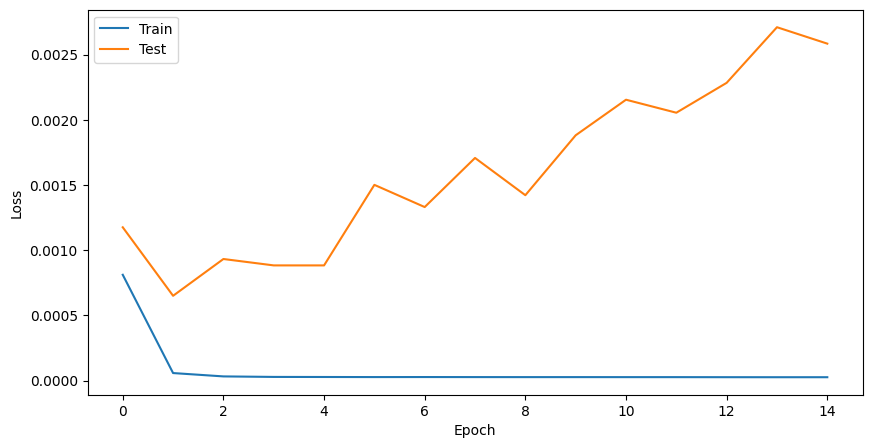

In [66]:
# Plot the loss curve for training and testing
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)

# Initialize an empty list to store model predictions and targets for visualization
predictions_list_train = []
targets_list_train = []
predictions_list_test = []
targets_list_test = []

loss_train, lr_train, predictions_train, targets_train = run_epoch(train_dataloader, is_training=False)
loss_test, lr_test, predictions_test, targets_test = run_epoch(test_dataloader, is_training=False)

train_losses.append(loss_train)
test_losses.append(loss_test)

In [68]:
# Obtain minimum and maximum values from the original dataset
min_value = dataset.scaler.data_min_[3]
max_value = dataset.scaler.data_max_[3]

# Manually inverse scale the data
predictions_array_train = predictions_train * (max_value - min_value) + min_value
targets_array_train = targets_train * (max_value - min_value) + min_value
predictions_array_test = predictions_test * (max_value - min_value) + min_value
targets_array_test = targets_test * (max_value - min_value) + min_value

In [69]:
# Plot portions of the predictions vs the targets for training and testing data based on the number of prediction steps

targets_train_flattened = targets_array_train.flatten()[::prediction_steps]
predictions_train_flattened = predictions_array_train.flatten()[::prediction_steps]
targets_test_flattened = targets_array_test.flatten()[::prediction_steps]
predictions_test_flattened = predictions_array_test.flatten()[::prediction_steps]

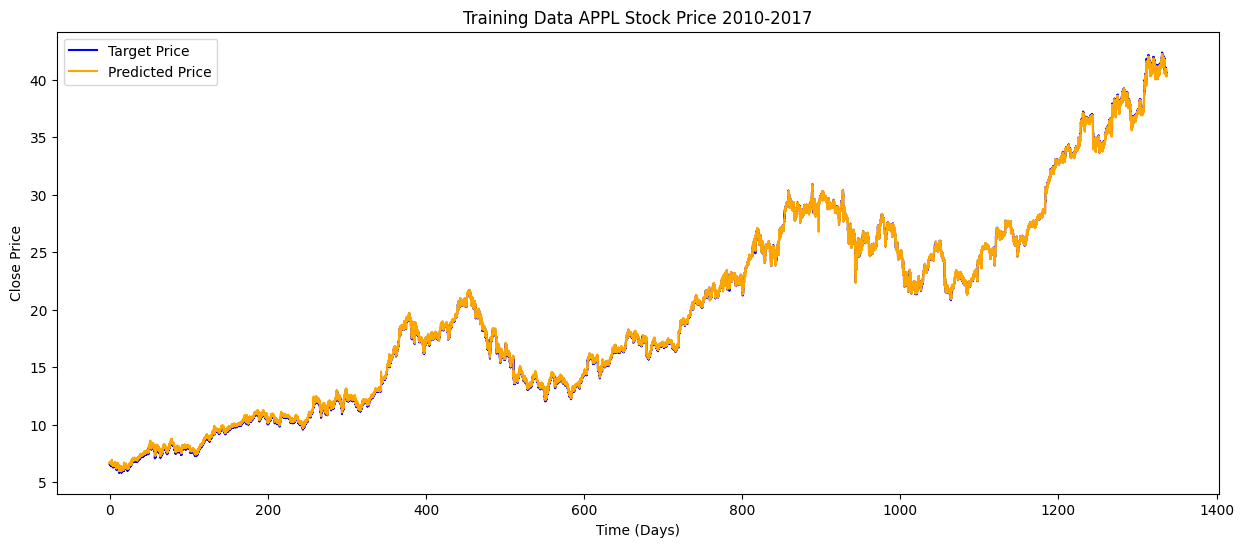

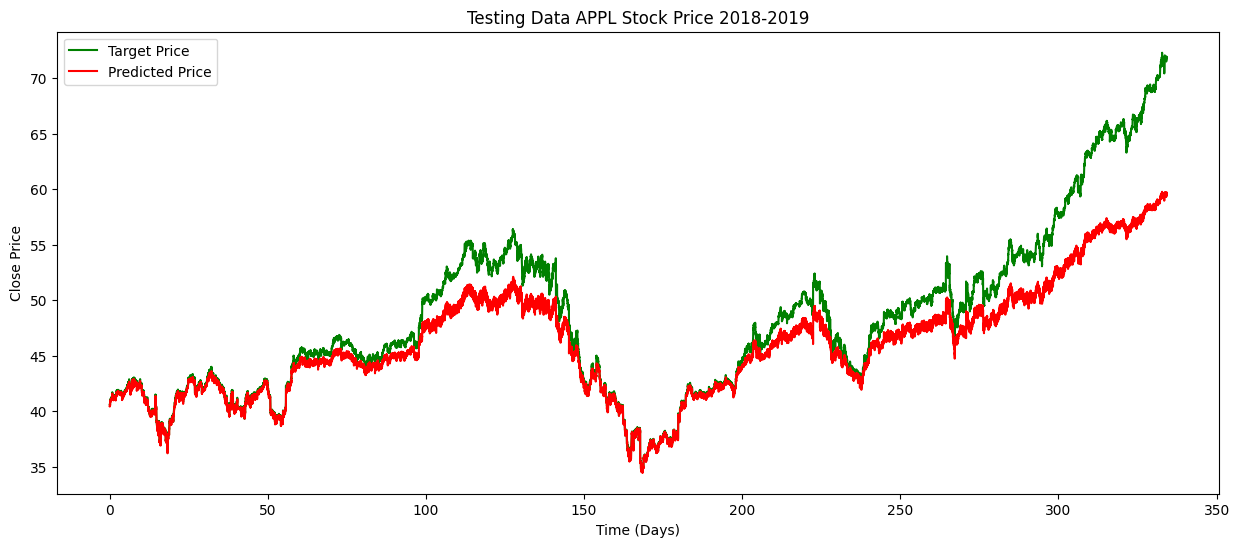

In [70]:
time_interval_minutes = 10

time_steps_days = np.arange(0, targets_train_flattened.shape[0]) * time_interval_minutes / (60 * 24)

# Plot every 50th data point for training data
plt.figure(figsize=(15, 6))
plt.plot(time_steps_days, targets_train_flattened, label='Target Price', color='blue')
plt.plot(time_steps_days, predictions_train_flattened, label='Predicted Price', color='orange')

plt.xlabel('Time (Days)')
plt.ylabel('Close Price')
plt.title('Training Data APPL Stock Price 2010-2017')
plt.legend()
plt.show()

# Plot every 50th data point for testing data
time_steps_days = np.arange(0, targets_test_flattened.shape[0]) * time_interval_minutes / (60 * 24)
plt.figure(figsize=(15, 6))
plt.plot(time_steps_days, targets_test_flattened, label='Target Price', color='green')
plt.plot(time_steps_days, predictions_test_flattened, label='Predicted Price', color='red')

plt.xlabel('Time (Days)')
plt.ylabel('Close Price')
plt.title('Testing Data APPL Stock Price 2018-2019')
plt.legend()
plt.show()